In [1]:
!python3 -m pip install --upgrade 'sqlalchemy < 2.0'

import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10


Загрузим посты и обработаем их, сделав "эмбеддинги" через tfidf

In [2]:
### Загрузим посты

posts_info = pd.read_sql(
    """
      SELECT *
      FROM public.post_text_df
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [3]:
import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to /root/nltk_data...


TfidfVectorizer(preprocessor=<function preprocessing at 0x7f3c341a7910>,
                stop_words='english')

In [4]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

### Генерим фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

### Пытаемся кластеризовать тексты

from sklearn.decomposition import PCA

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

posts_info['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.478815,0.538907,0.441926,0.464978,0.528160,0.530666,0.501635,0.154191,0.681960,0.392327,0.513678,0.452120,0.439661,0.444761,0.570748
1,0.341924,0.437189,0.293476,0.327691,0.413074,0.272745,0.375512,0.254587,0.568612,0.164572,0.388428,0.296981,0.294949,0.305576,0.478302
2,0.362211,0.472450,0.315778,0.355466,0.434387,0.478077,0.389236,0.124216,0.522959,0.242063,0.419131,0.345956,0.314987,0.333522,0.490381
3,0.320704,0.436487,0.265651,0.294392,0.388527,0.429923,0.352316,0.220621,0.437462,0.163164,0.388497,0.290156,0.257755,0.298324,0.455949
4,0.259506,0.392123,0.179513,0.232803,0.343281,0.391132,0.295403,0.281431,0.495458,0.096496,0.351792,0.239352,0.162797,0.231119,0.455724


In [5]:
posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,7,0.478815,0.538907,0.441926,...,0.530666,0.501635,0.154191,0.681960,0.392327,0.513678,0.452120,0.439661,0.444761,0.570748
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,9,0.341924,0.437189,0.293476,...,0.272745,0.375512,0.254587,0.568612,0.164572,0.388428,0.296981,0.294949,0.305576,0.478302
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,7,0.362211,0.472450,0.315778,...,0.478077,0.389236,0.124216,0.522959,0.242063,0.419131,0.345956,0.314987,0.333522,0.490381
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,9,0.320704,0.436487,0.265651,...,0.429923,0.352316,0.220621,0.437462,0.163164,0.388497,0.290156,0.257755,0.298324,0.455949
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,9,0.259506,0.392123,0.179513,...,0.391132,0.295403,0.281431,0.495458,0.096496,0.351792,0.239352,0.162797,0.231119,0.455724


In [6]:
posts_info.to_sql(
   "posts_info_features",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",
    schema="public",
    if_exists='replace'
)

23

In [7]:
### Почистим переменные

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df

import gc

gc.collect()

1154

Загрузим "клики", пользовательскую информацию и подготовим датасет к моделированию

In [8]:
### Попробуем забрать, скажем, 8 миллионов действий пользователей
### Почистим "like"
### Сразу же в запросе выделим

feed_data = pd.read_sql(
    """
      SELECT
        cast(extract(hour from timestamp) as int) as hour,
        cast(extract(month from timestamp) as int) as month,
        timestamp,
        public.feed_data.user_id,
        post_id,
        gender,
        age,
        country,
        city,
        exp_group,
        os,
        source,
        target

      FROM public.feed_data

      JOIN public.user_data
      ON public.feed_data.user_id = public.user_data.user_id

      WHERE action = 'view'

      LIMIT 5000000
    """,

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

feed_data.head()

,hour,month,timestamp,user_id,post_id,gender,age,country,city,exp_group,os,source,target
0,15,10,2021-10-21 15:32:40,123469,2333,0,31,Russia,Izhevsk,4,Android,organic,0
1,15,10,2021-10-21 15:34:59,123469,5817,0,31,Russia,Izhevsk,4,Android,organic,0
2,15,10,2021-10-21 15:35:41,123469,4101,0,31,Russia,Izhevsk,4,Android,organic,0
3,15,10,2021-10-21 15:36:01,123469,4934,0,31,Russia,Izhevsk,4,Android,organic,0
4,15,10,2021-10-21 15:38:39,123469,2925,0,31,Russia,Izhevsk,4,Android,organic,1


In [9]:
df = pd.merge(
    feed_data,
    posts_info.drop('text', axis=1),
    on='post_id',
    how='left'
)

del feed_data
del posts_info

df = df.set_index(['user_id', 'post_id'])

df.head(50)

hour  month           timestamp  gender  age country  \
user_id post_id                                                         
123469  2333       15     10 2021-10-21 15:32:40       0   31  Russia   
        5817       15     10 2021-10-21 15:34:59       0   31  Russia   
        4101       15     10 2021-10-21 15:35:41       0   31  Russia   
        4934       15     10 2021-10-21 15:36:01       0   31  Russia   
        2925       15     10 2021-10-21 15:38:39       0   31  Russia   
        5283       15     10 2021-10-21 15:39:32       0   31  Russia   
        3196       15     10 2021-10-21 15:40:17       0   31  Russia   
        5317       15     10 2021-10-21 15:41:03       0   31  Russia   
        3542       15     10 2021-10-21 15:42:57       0   31  Russia   
        4346       15     10 2021-10-21 15:43:53       0   31  Russia   
        2664       15     10 2021-10-21 15:45:55       0   31  Russia   
        2545       15     10 2021-10-21 15:48:31       0   31  Russia   
        6684       15     10 2021-10-21 15:51:20       0   31  Russia   
        5003       15     10 2021-10-21 15:51:41       0   31  Russia   
        3293       15     10 2021-10-21 15:54:18       0   31  Russia   
        2132       15     10 2021-10-21 15:55:39       0   31  Russia   
        541        15     10 2021-10-21 15:58:05       0   31  Russia   
        3938       15     10 2021-10-21 15:59:01       0   31  Russia   
        763        16     10 2021-10-21 16:00:56       0   31  Russia   
        1349       16     10 2021-10-21 16:03:09       0   31  Russia   
        1196       16     10 2021-10-21 16:04:15       0   31  Russia   
        1469       16     10 2021-10-21 16:04:39       0   31  Russia   
        2327       16     10 2021-10-21 16:06:43       0   31  Russia   
        1119       16     10 2021-10-21 16:07:00       0   31  Russia   
        6083       16     10 2021-10-21 16:08:08       0   31  Russia   
        991        16     10 2021-10-21 16:10:39       0   31  Russia   
        472        16     10 2021-10-21 16:11:38       0   31  Russia   
        821        16     10 2021-10-21 16:12:36       0   31  Russia   
        3449       16     10 2021-10-21 16:13:35       0   31  Russia   
        1025       16     10 2021-10-21 16:14:38       0   31  Russia   
        970        16     10 2021-10-21 16:17:08       0   31  Russia   
        2718       16     10 2021-10-21 16:19:51       0   31  Russia   
        1845       16     10 2021-10-21 16:21:55       0   31  Russia   
        3921       16     10 2021-10-21 16:24:18       0   31  Russia   
        5457        7     10 2021-10-24 07:32:47       0   31  Russia   
        2705        7     10 2021-10-24 07:33:14       0   31  Russia   
        819         7     10 2021-10-24 07:33:52       0   31  Russia   
        4971        7     10 2021-10-24 07:36:09       0   31  Russia   
        5208        7     10 2021-10-24 07:38:19       0   31  Russia   
        47          7     10 2021-10-24 07:39:44       0   31  Russia   
        4329        7     10 2021-10-24 07:42:12       0   31  Russia   
        4587        7     10 2021-10-24 07:44:25       0   31  Russia   
        7207        7     10 2021-10-24 07:45:57       0   31  Russia   
        854         7     10 2021-10-24 07:48:19       0   31  Russia   
        1595        7     10 2021-10-24 07:49:29       0   31  Russia   
        7251        7     10 2021-10-24 07:50:59       0   31  Russia   
        5544        7     10 2021-10-24 07:53:57       0   31  Russia   
        5011        7     10 2021-10-24 07:54:29       0   31  Russia   
        1518        7     10 2021-10-24 07:55:51       0   31  Russia   
        993         7     10 2021-10-24 07:58:12       0   31  Russia   

                    city  exp_group       os   source  ...  \
user_id post_id                                        ...   
123469  2333     Izhevsk          4  Android  organic  ...   
        5817     Izhevsk          

In [10]:
%whos

Variable          Type         Data/Info
----------------------------------------
TfidfVectorizer   type         <class 'sklearn.feature_e<...>on.text.TfidfVectorizer'>
df                DataFrame                     hour  mo<...>000000 rows x 31 columns]
gc                module       <module 'gc' (built-in)>
nltk              module       <module 'nltk' from '/usr<...>ckages/nltk/__init__.py'>
pd                module       <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
re                module       <module 're' from '/usr/lib/python3.10/re.py'>
string            module       <module 'string' from '/u<...>ib/python3.10/string.py'>


Валидация, обработка фичей и обучение катбуста

In [11]:
### Предлагаю начать с относительно простой модели
### Например, с решающего дерева
### А потом посмотреть уже в сторону бустингов

### Как валидировать? Как разобьем на train и test?
### Предлагаю по времени, так как данные имеют
### Временную структуру! Хотим корректно оценивать
### Вероятности для будущих рекомендаций

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:44:39'), Timestamp('2021-10-01 06:02:14'))

In [12]:
### За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((4163690,), (836310,))

In [13]:
del df

In [14]:
### Синхронизируем порядок колонок с первоначальным разбором

cols_ = [
    'topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
    'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
    'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
    'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
    'DistanceTo10thCluster', 'DistanceTo11thCluster',
    'DistanceTo12thCluster', 'DistanceTo13thCluster',
    'DistanceTo14thCluster', 'DistanceTo15thCluster', 'gender', 'age',
    'country', 'city', 'exp_group', 'os', 'source', 'hour', 'month'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

del cols_

In [15]:
### Начнем с решающего дерева!

!pip install category_encoders

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

### Cохраним индексы этих колонок

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([("column_transformer",
                     col_transform),

                    ("decision_tree",
                     DecisionTreeClassifier())])

pipe_dt.fit(X_train, y_train)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [16]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9089417842127028
Качество на тесте: 0.5375317376593526


In [17]:
### Теперь обучим катбуст!

!pip install catboost

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2,
                              random_seed=100)

catboost.fit(X_train, y_train, object_cols)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.4 MB/s eta 0:00:00
0:	learn: 0.3590349	total: 3.29s	remaining: 5m 25s
1:	learn: 0.3511971	total: 6.24s	remaining: 5m 5s
2:	learn: 0.3493287	total: 9.78s	remaining: 5m 16s
3:	learn: 0.3485587	total: 12.1s	remaining: 4m 51s
4:	learn: 0.3480629	total: 14.2s	remaining: 4m 29s
5:	learn: 0.3479158	total: 16.5s	remaining: 4m 19s
6:	learn: 0.3470137	total: 18.6s	remaining: 4m 6s
7:	learn: 0.3469460	total: 21.5s	remaining: 4m 6s
8:	learn: 0.3468729	total: 24s	remaining: 4m 3s
9:	learn: 0.3468008	total: 26.1s	remaining: 3m 55s
10:	learn: 0.3464092	total: 28.2s	remaining: 3m 48s
11:	learn: 0.3463919	total: 30.1s	remaining: 3m 40s
12:	learn: 0.3462504	total: 32.3s	remaining: 3m 35s
13:	learn: 0.3462145	total: 35.7s	remaining: 3m 39s
14:	learn: 0.3459307	total: 39.4s	remaining: 3m 43s
15:	learn: 0.3456948	total: 41.5s	remaining: 3m 37s
16:	l

In [18]:
### Замерим качество работы такой модели
### Возьмем ROC-AUC

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6636876226769284
Качество на тесте: 0.6460479793671771


In [19]:
### Сохраним модель

catboost.save_model(
    'catboost_model',
    format="cbm"
)

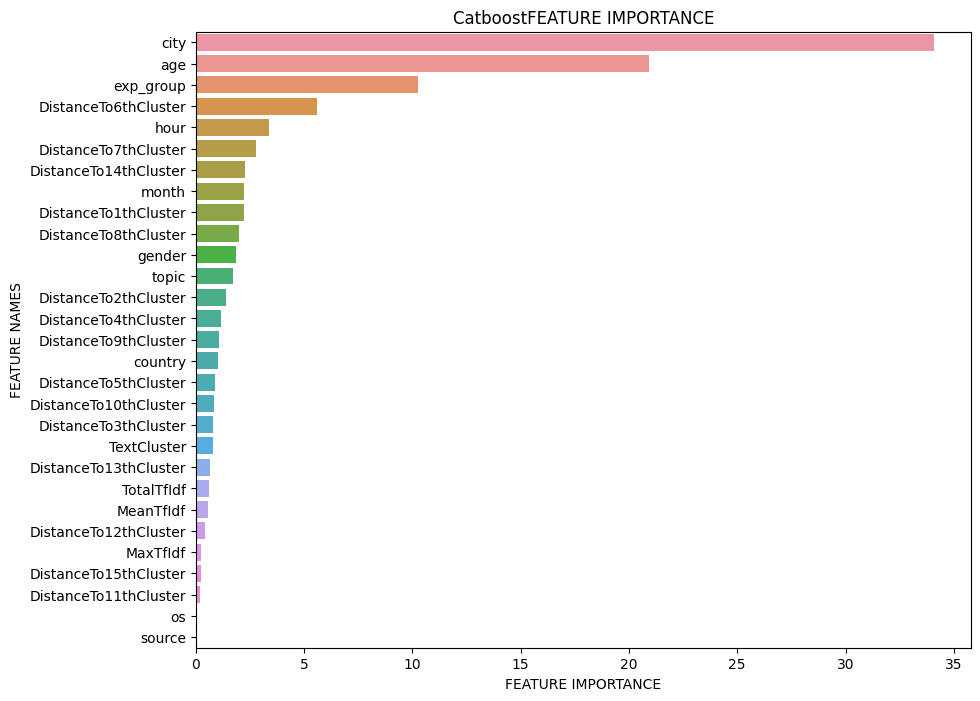

In [20]:
### Из любопытства посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(catboost.feature_importances_,X_train.columns,'Catboost')